In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#IEEE Fraud Detection Competition

In this project I'll do some exploratory data analysis on the IEEE Fraud Detection dataset.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
import warnings
warnings.simplefilter('ignore')

**Data**

In the dataset we have to predict the probability that an online transaction is fraudulent, as denoted by the binary target **isFraud**.

The data is broken into two files identity and transaction, which are joined by **TransactionID**. Not all transactions have corresponding identity information.

In [0]:
train_transaction = pd.read_csv('/content/drive/My Drive/ieee fraud detection/train_transaction.csv')
test_transaction = pd.read_csv('/content/drive/My Drive/ieee fraud detection/test_transaction.csv')

train_identity = pd.read_csv('/content/drive/My Drive/ieee fraud detection/train_identity.csv')
test_identity = pd.read_csv('/content/drive/My Drive/ieee fraud detection/test_identity.csv')

In [5]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [6]:
# Lets see how many values match in transaction dataset and identity dataset

print(np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique())))
print(np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique())))

144233
141907




*   24.4% of TransactionIDs in **train** (144233 / 590540) have an associated train_identity.

*   28.0% of TransactionIDs in **test** (144233 / 590540) have an associated train_identity.




##Train vs Test are Time Series Split

The **TransactionDT** feature is a timedelta from a given reference datetime (not an actual timestamp). One early discovery about the data is that the train and test appear to be split by time. There is a slight gap in between, but otherwise the training set is from an earlier period of time and test is from a later period of time. This will impact which cross validation techniques should be used.

We will look into this more when reviewing differences in distribution of features between train and test.

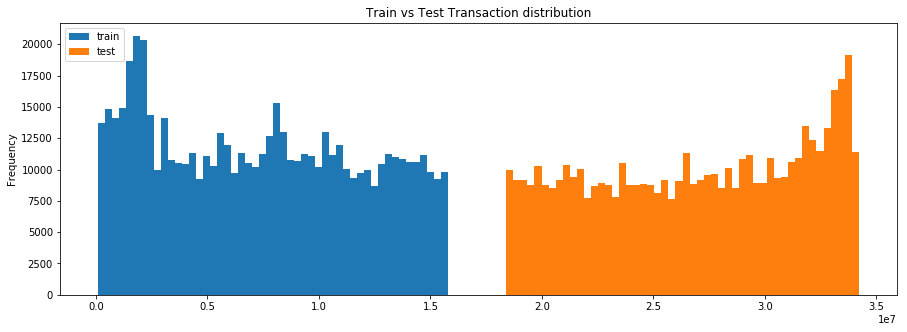

In [7]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15,5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test Transaction distribution')

test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()

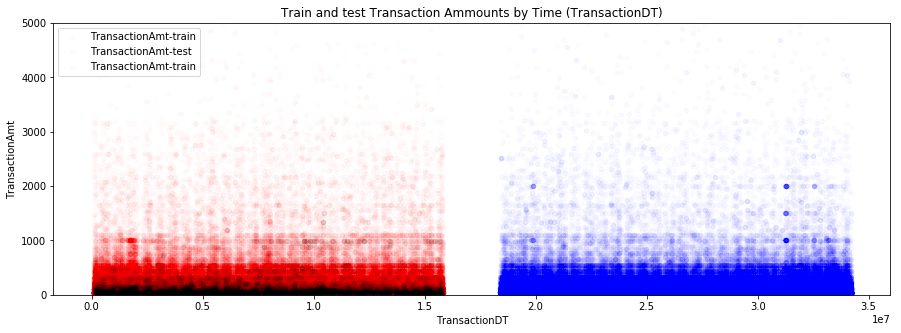

In [8]:
ax = train_transaction.plot(x='TransactionDT',
                            y='TransactionAmt',
                            kind='scatter',
                            alpha=0.01,
                            label='TransactionAmt-train',
                            title='Train and test Transaction Amounts by Time (TransactionDT)',
                            ylim=(0,5000),
                            figsize=(15,5),
                            color='r')

test_transaction.plot(x='TransactionDT',
                      y='TransactionAmt',
                      kind='scatter',
                      label='TransactionAmt-test',
                      alpha=0.01,
                      color='blue',
                      ylim=(0,5000),
                      ax=ax)

# Plot Fraud as Black
train_transaction.loc[train_transaction['isFraud'] == 1] \
    .plot(x='TransactionDT',
         y='TransactionAmt',
         kind='scatter',
         alpha=0.01,
         label='TransactionAmt-train',
         title='Train and test Transaction Ammounts by Time (TransactionDT)',
         ylim=(0, 5000),
         color='black',
         figsize=(15, 5),
         ax=ax)

##Distribution of Target in Training Set

In [9]:
print('  {:.4f}% of Transactions are fraud in train '.format(train_transaction['isFraud'].mean() * 100))

  3.4990% of Transactions are fraud in train 


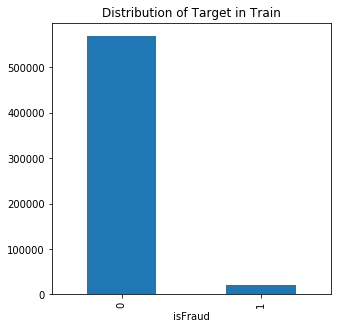

In [10]:
train_transaction.groupby('isFraud').count()['TransactionID']\
                  .plot(kind='bar', title='Distribution of Target in Train',
                        figsize=(5,5))

##Transaction Amount

The ammount of transaction. I've taken a log transform in some of these plots to better show the distribution- otherwise the few, very large transactions skew the distribution. Because of the log transfrom, any values between 0 and 1 will appear to be negative.

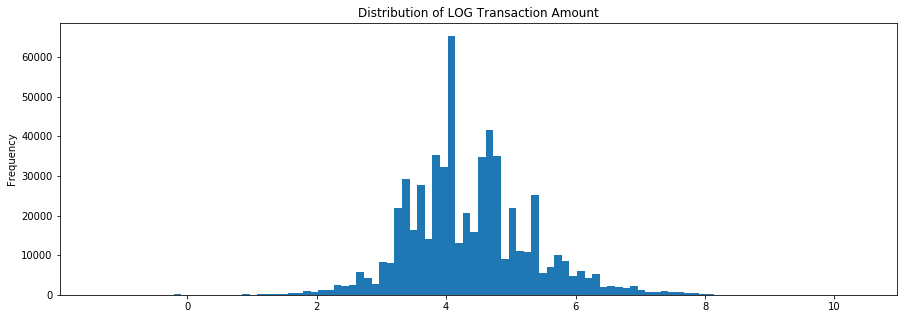

In [11]:
train_transaction['TransactionAmt'].apply(np.log)\
                  .plot(kind='hist',
                        bins=100,
                        figsize=(15,5),
                        title='Distribution of LOG Transaction Amount')

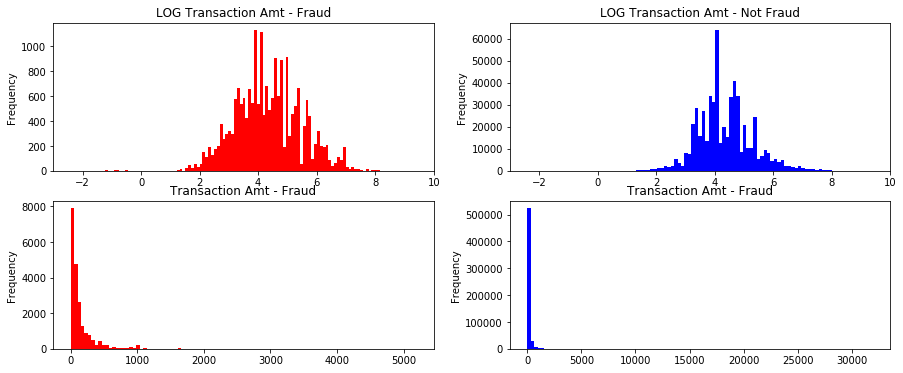

In [12]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(15,6))

train_transaction.loc[train_transaction['isFraud']==1]['TransactionAmt']\
                .apply(np.log)\
                .plot(kind='hist',
                      bins=100,
                      color='red',
                      title='LOG Transaction Amt - Fraud',
                      ax=ax1,
                      xlim=(-3,10))

train_transaction.loc[train_transaction['isFraud']==0]['TransactionAmt']\
                .apply(np.log)\
                .plot(kind='hist',
                      bins=100,
                      color='blue',
                      title='LOG Transaction Amt - Not Fraud',
                      ax=ax2,
                      xlim=(-3,10))

train_transaction.loc[train_transaction['isFraud']==1]['TransactionAmt']\
                .plot(kind='hist',
                      bins=100,
                      color='red',
                      title='Transaction Amt - Fraud',
                      ax=ax3)
                      

train_transaction.loc[train_transaction['isFraud']==0]['TransactionAmt']\
                .plot(kind='hist',
                      bins=100,
                      color='blue',
                      title='Transaction Amt - Fraud',
                      ax=ax4)
                                      




*   Fraudulent charges seems to have higher average transaction amount.



In [13]:
print('Mean transaction amount for fraud is {}'.format(train_transaction.loc[train_transaction['isFraud']==1]['TransactionAmt'].mean()))
print('Mean transaction amount for non-fraud is {}'.format(train_transaction.loc[train_transaction['isFraud']==0]['TransactionAmt'].mean()))

Mean transaction amount for fraud is 149.2447785897534
Mean transaction amount for non-fraud is 134.51166457896034


##ProductCD

For now we don't know exactly what these values represent.

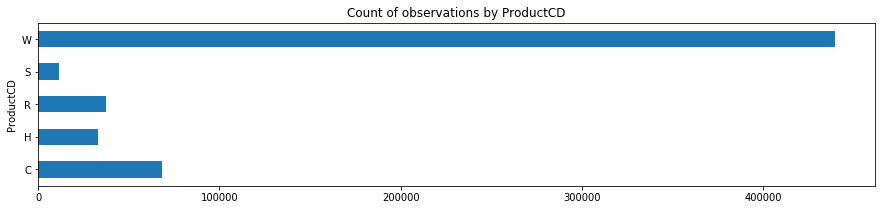

In [14]:
train_transaction.groupby('ProductCD')['TransactionID'].count()\
                  .sort_index()\
                  .plot(kind='barh',
                        title='Count of observations by ProductCD',
                        figsize=(15,3))

**W** has the most count and **C** has the least.

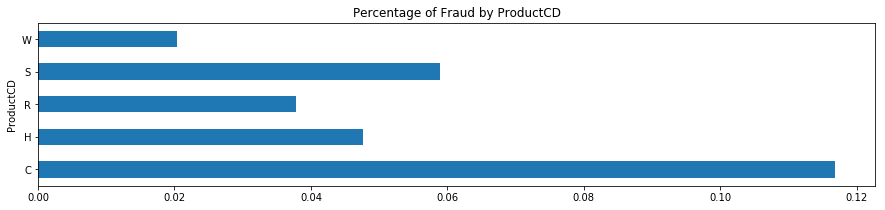

In [15]:
train_transaction.groupby('ProductCD')['isFraud']\
                .mean().sort_index()\
                .plot(kind='barh',
                      figsize=(15,3),
                      title='Percentage of Fraud by ProductCD')

ProductCD **C** has the most fraud(greater than 11%).
ProductCD **W** has the least fraud(around 2%).


#Categorical Features - Transaction

We have been told in data description that following columns are categorical:

*   ProductCD

*   emaildomain

*   card1 - card6

*   addr1, addr2

*   P_emaildomain

*   R_emaildomain

*  M1 - M9 




**card1 - card6**

We have been these all are categorical, even though some appear numeric.


In [16]:
card_cols = [c for c in train_transaction if 'card' in c]
train_transaction[card_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 6 columns):
card1    590540 non-null int64
card2    581607 non-null float64
card3    588975 non-null float64
card4    588963 non-null object
card5    586281 non-null float64
card6    588969 non-null object
dtypes: float64(3), int64(1), object(2)
memory usage: 27.0+ MB


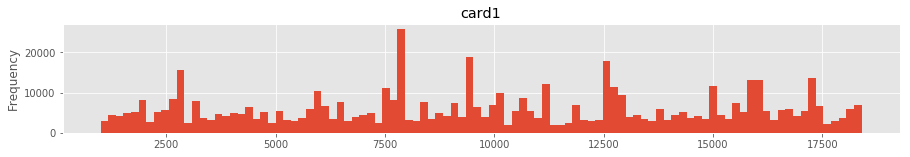

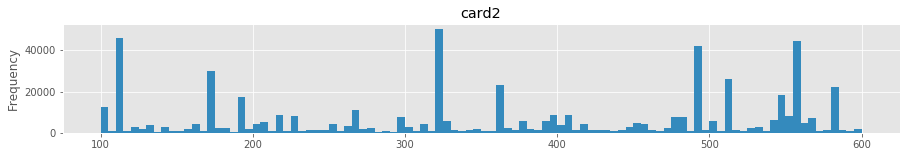

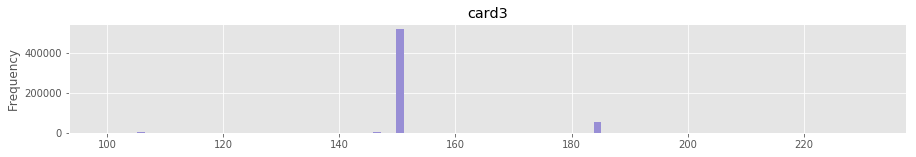

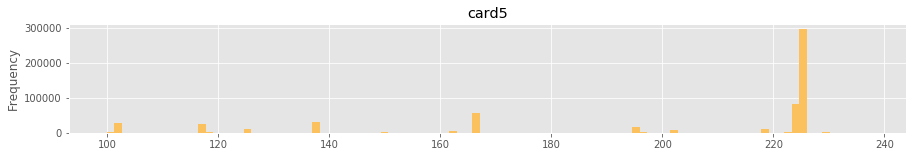

In [17]:
plt.style.use('ggplot')

color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

color_idx = 0

for c in card_cols:
  if train_transaction[c].dtype in ['int64', 'float64']:
    train_transaction[c].plot(kind='hist',
                              title=c,
                              bins=100,
                              figsize=(15,2),
                              color=color_pal[color_idx])
  color_idx+=1
  plt.show()

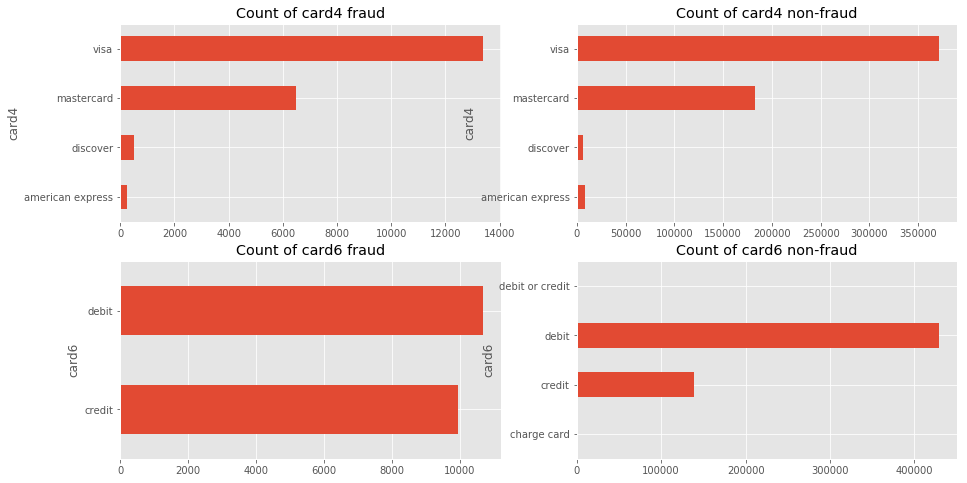

In [18]:
train_transaction_fr = train_transaction.loc[train_transaction['isFraud'] == 1]
train_transaction_nofr = train_transaction.loc[train_transaction['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_transaction_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_transaction_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_transaction_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_transaction_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')

**addr1 & addr2**

The data description states that these are categorical even though they look numeric. Could they be the address value?

In [19]:
print(' addr1 - has {} NA values'.format(train_transaction['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train_transaction['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


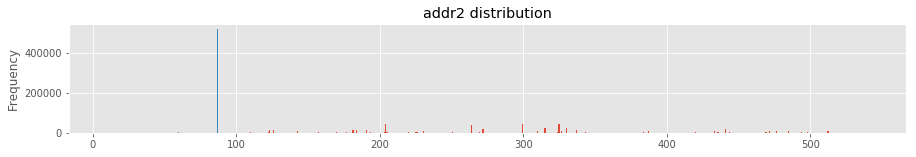

In [20]:
train_transaction['addr1'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr1 distribution')
train_transaction['addr2'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr2 distribution')

**dist1 & dist2**

Plotting with logx to better show the distribution. Possibly this could be the distance of the transaction vs. the card owner's home/work address. This is just a guess.

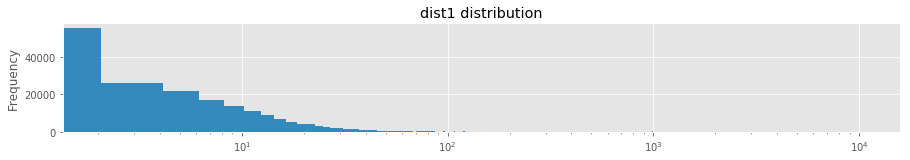

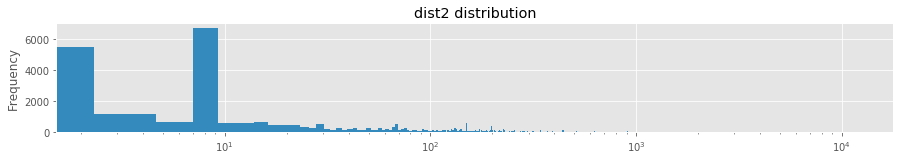

In [21]:
train_transaction['dist1'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist1 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()
train_transaction['dist2'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist2 distribution',
                                color=color_pal[1],
                                logx=True)

**C1 - C14**

Because we are provided many numerical columns, we can create a pairplot to plot feature interactions. I know these plots can be hard to read, but it is helpful for gaining intution about potential feature interactions and if certain features have more variance than others

In [22]:
c_cols =  [c for c in train_transaction if c[0]=='C']
c_cols

['C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14']

In [23]:
train_transaction[c_cols].head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


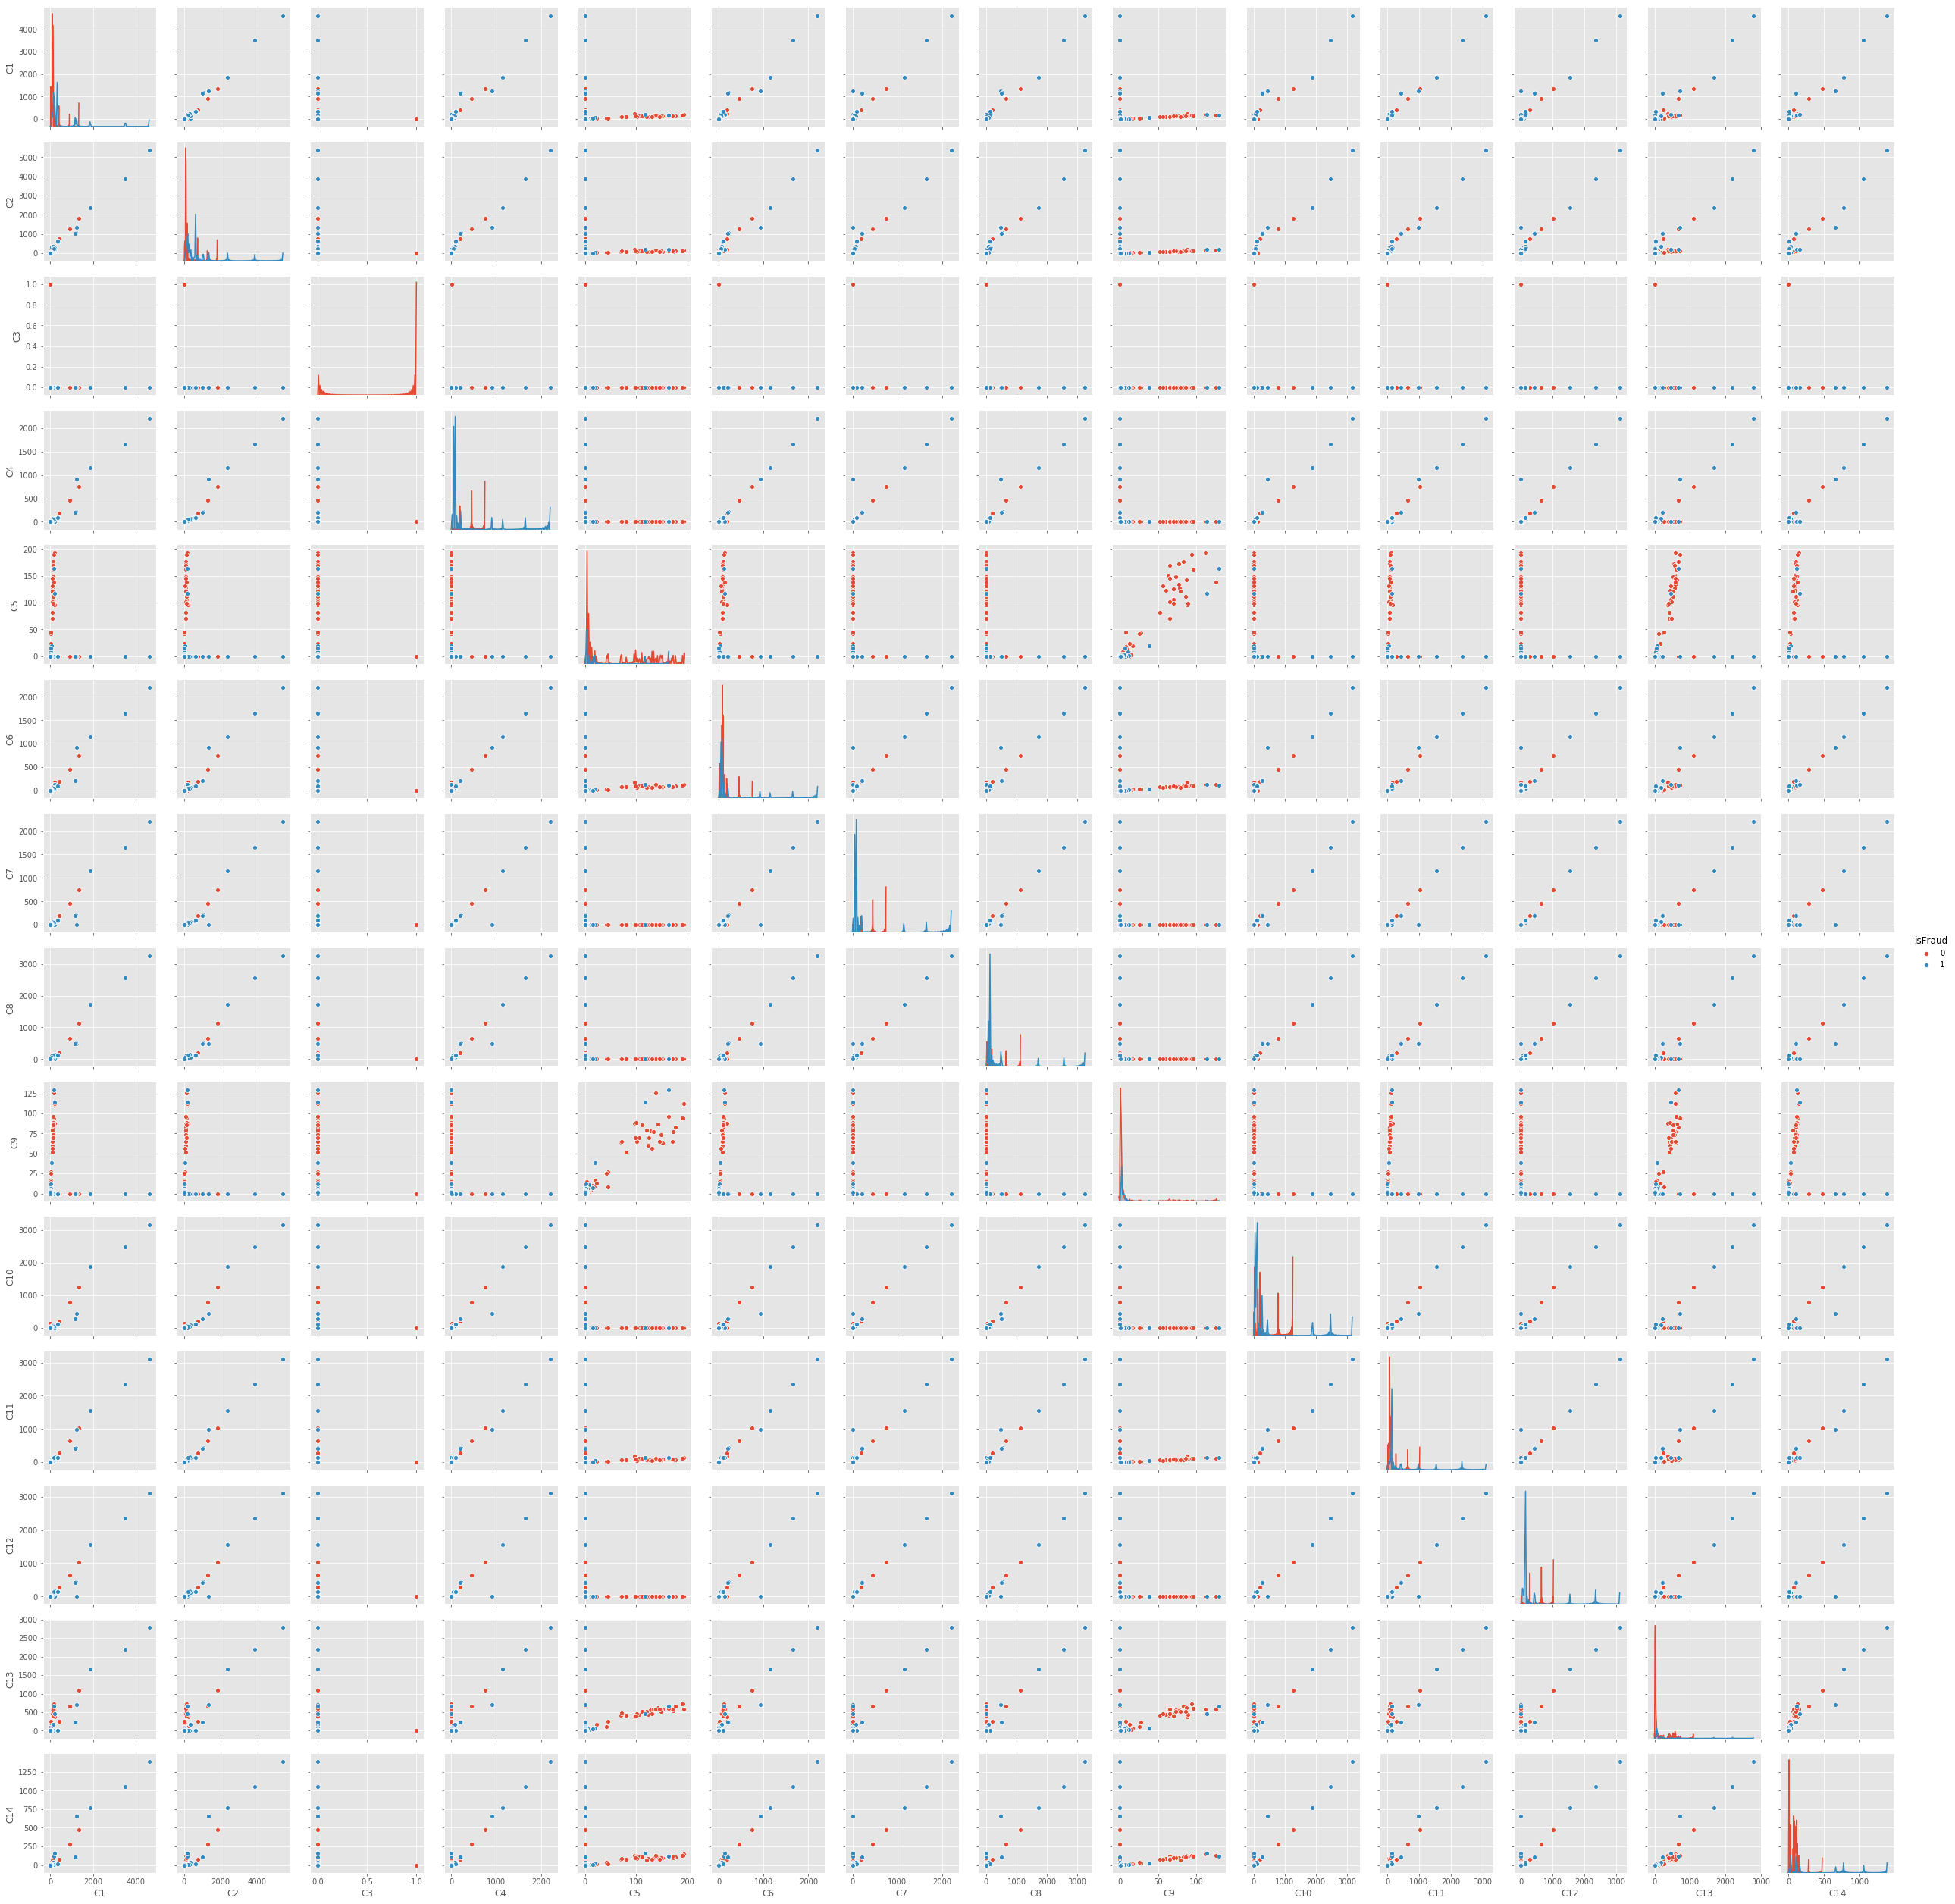

In [24]:
# Sample 500 fraud and 500 non-fraud examples to plot
sampled_train = pd.concat([train_transaction.loc[train_transaction['isFraud'] == 0].sample(500),
          train_transaction.loc[train_transaction['isFraud'] == 1].sample(500)])

sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=c_cols)

**D1-D9**

Similarly for features D1-D9. In these plots we can see some linear and non-linear interactions between features. We may want to create additional features using these interactions if we think it would help our model better find relationship between fraud and non-fraud observations.

In [25]:
d_cols = [c for c in train_transaction if c[0] == 'D']
train_transaction[d_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


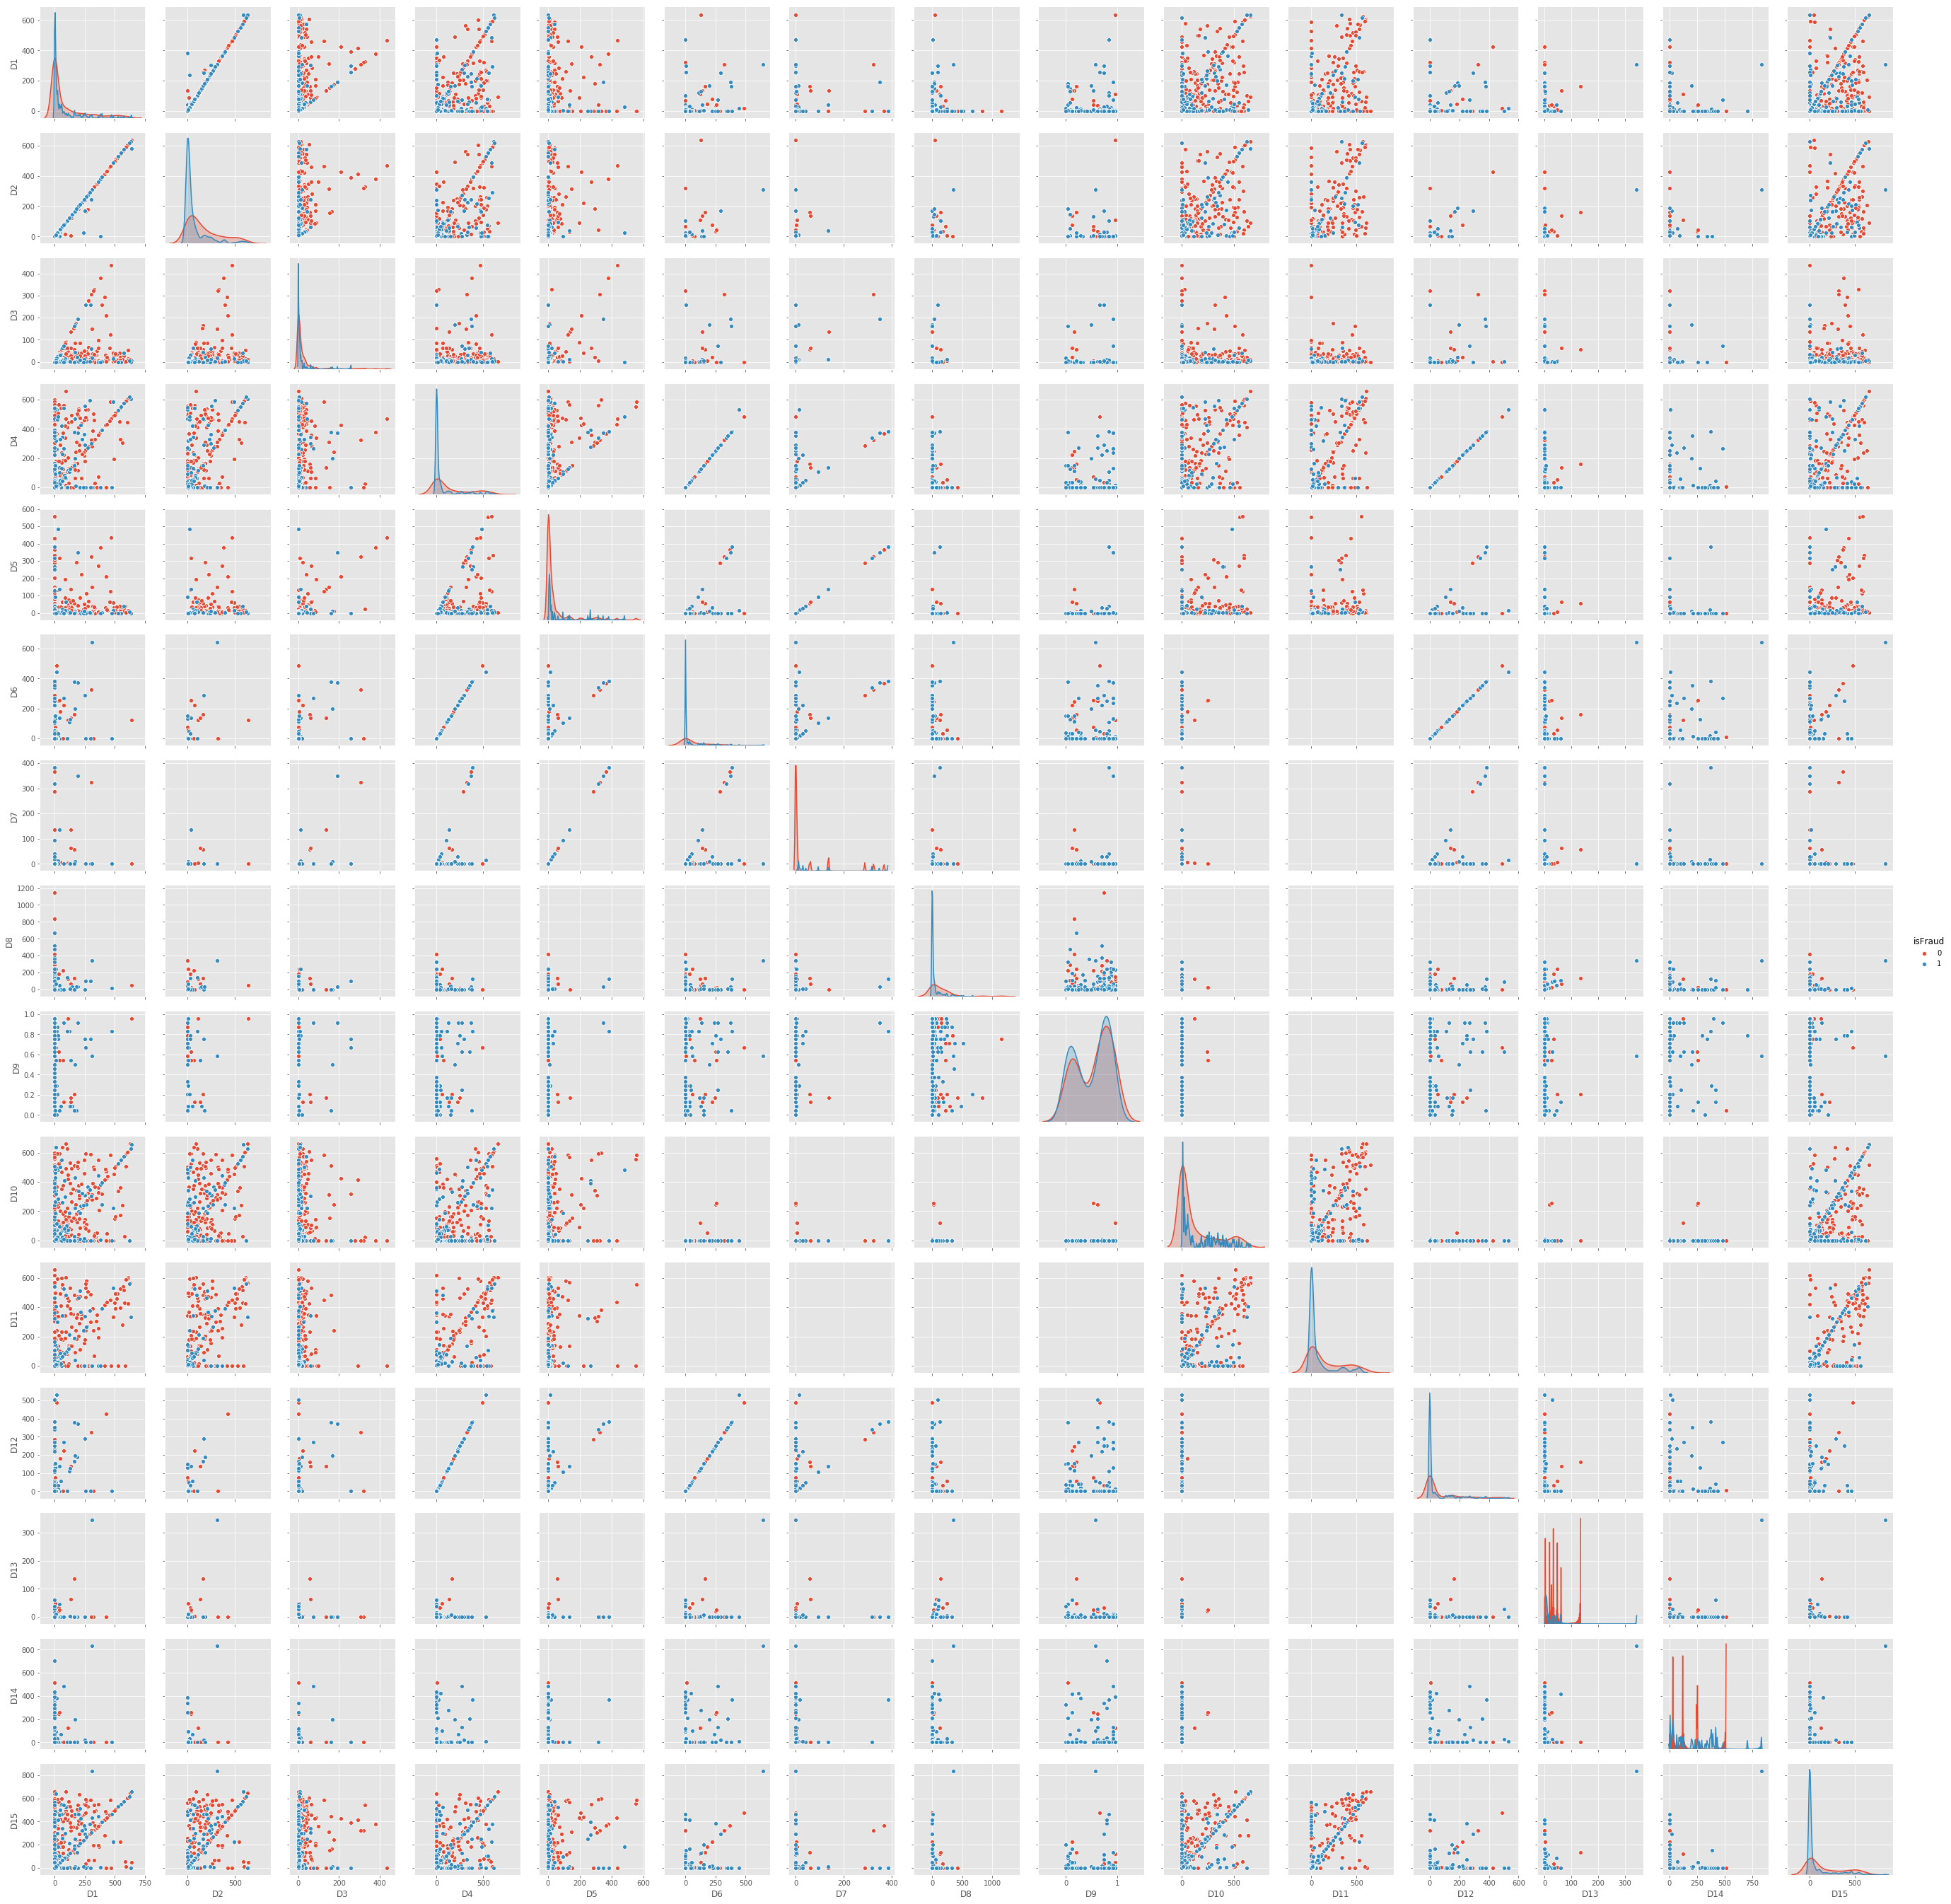

In [26]:
sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=d_cols)
plt.show()

##M1-M9


*   Values are T, F or NaN.
*   Column M4 appears to be different with values like M2 and M0.




In [30]:
m_cols = [c for c in train_transaction if c[0]=='M']
train_transaction[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


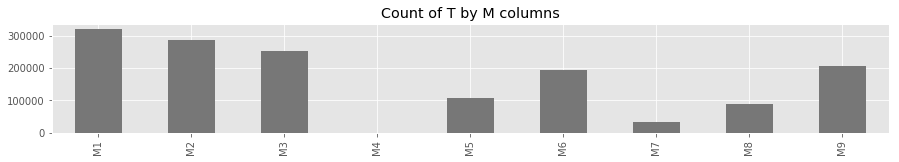

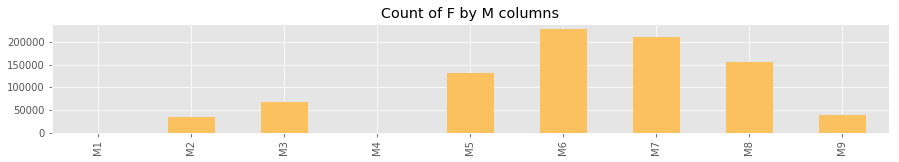

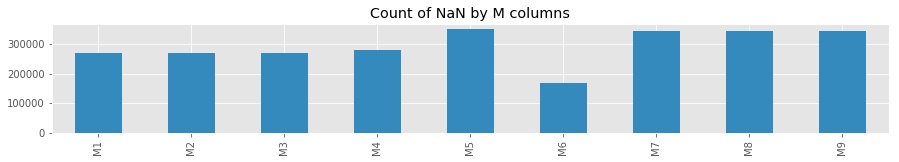

In [34]:
(train_transaction[m_cols]=="T").sum().plot(kind='bar',
                                            figsize=(15,2),
                                            title='Count of T by M columns',
                                            color=color_pal[3])
plt.show()
(train_transaction[m_cols]=="F").sum().plot(kind='bar',
                                            figsize=(15,2),
                                            title='Count of F by M columns',
                                            color=color_pal[4])
plt.show()
(train_transaction[m_cols].isna()).sum().plot(kind='bar',
                                            figsize=(15,2),
                                            title='Count of NaN by M columns',
                                            color=color_pal[1])
plt.show()

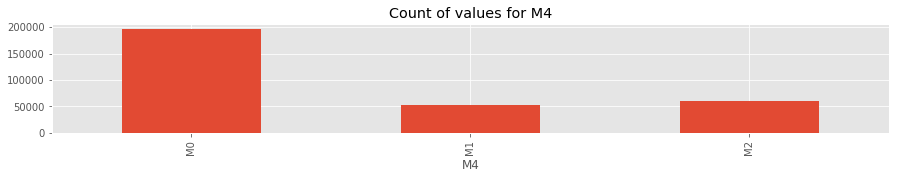

In [36]:
# Looking at M4 column since it is different than the others

train_transaction.groupby('M4')['TransactionID'].count()\
                  .plot(kind='bar',
                        title='Count of values for M4',
                        figsize=(15,2))

##V1 - V339

Lots of 1s, 0s, NaNs and some large values.

In [38]:
v_cols = [c for c in train_transaction if c[0]=='V']
train_transaction[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
train_transaction['v_mean'] = train_transaction[v_cols].mean(axis=1)

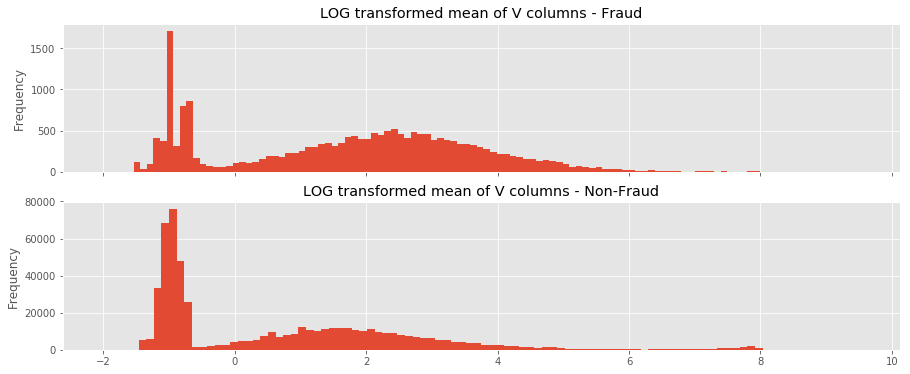

In [41]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))

train_transaction.loc[train_transaction['isFraud']==1]['v_mean']\
                .apply(np.log)\
                .plot(kind='hist',
                      bins=100,
                      title='LOG transformed mean of V columns - Fraud',
                      ax=ax1)

train_transaction.loc[train_transaction['isFraud']==0]['v_mean']\
                .apply(np.log)\
                .plot(kind='hist',
                      bins=100,
                      title='LOG transformed mean of V columns - Non-Fraud',
                      ax=ax2)

So this was the EDA of IEEE Fraud Detection dataset. We can use this analysis further for cleaning and feature engineering purposes.